# River or not river using PCA from satellite images

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

Below is the code to load the data into the tensors.

In [2]:
def get_data(path):
    img = Image.open(path, 'r')
    p = np.array(list(img.getdata())).flatten()
    return p

truth = get_data('images/UDCV3.jpeg') 

img0 = get_data('images/1.gif')

img1 = get_data('images/2.gif')

img2 = get_data('images/3.gif')

img3 = get_data('images/4.gif')

# print(img3.shape[0])
x = img0.shape[0]

imgs = np.zeros((x, 4))
y = np.zeros(x)

for i in range(x):
    imgs[i][0] = img0[i]
    imgs[i][1] = img1[i]
    imgs[i][2] = img2[i]
    imgs[i][3] = img3[i]

    y[i] = 0 if truth[i] < 128 else 1

print(imgs)
# print(covariance(imgs))


#Prints the covariance matrix
print(np.cov(imgs.T))
# print(y)


[[ 9. 11. 12. 28.]
 [ 9. 11. 15. 27.]
 [ 6.  9. 12. 26.]
 ...
 [ 6.  6.  6. 11.]
 [ 6.  7.  5. 17.]
 [ 5.  6.  6.  8.]]
[[ 7.39056118  6.37133815  8.85835449  2.05945495]
 [ 6.37133815  6.60222402  8.85052835  3.57685562]
 [ 8.85835449  8.85052835 15.75011491  3.96733057]
 [ 2.05945495  3.57685562  3.96733057 37.80738645]]


The below function is for the dimensionality reduction purpose with k as a parameter which means number of components to be considered

In [3]:
def eigenize(X, k=None):
    C = np.cov(X.T)
    W, V = np.linalg.eig(C)
    V = V.T
    print(W)
    idx = W.argsort()[::-1]

    pv = np.array([V[idx[i]] for i in range(k)])
    # print(pv)
    # print(W[1]*pv[1])
    # print(pv[1].dot(C))

    U = pv.dot(X.T).T
    return pv, U

The following code removes the mean image from all the images, finds out the reduced set called eigen_images

In [4]:
mean = np.average(imgs, axis = 0)
# print(mean)
imgs = imgs - mean
mean = np.average(imgs, axis = 0)
# print(mean)

# cov_mat = np.cov(imgs.T)
# print(cov_mat)
k = 2
pv, new_imgs = eigenize(imgs, k)
print(new_imgs.shape)
print(pv)


[40.24007103 24.74509738  0.52635551  2.03876264]
(262144, 2)
[[ 0.17494902  0.20630134  0.28671959  0.91903453]
 [-0.45452022 -0.41536811 -0.68303992  0.3928577 ]]


Using the euclidean distance the class of the point is identified. 

In [5]:
def get_dist(p1,p2):
    l = p1.shape[0]
    d =0
    for i in range(0,l):
        d = d+ (p1[i]-p2[i])**2
        
    return np.sqrt(d)

def get_class(pt,y,data):
    e1,e2=0,0
    c1,c2=0,0
    
    for i in range(0,data.shape[0]):
        
        if(y[i]==0):
            e1 = e1+get_dist(pt,data[i])
            c1 = c1+1
        else:
            e2 = e2+get_dist(pt,data[i])
            c2=c2+1
    if((e1/c1) < (e2/c2)):
        return 0
    else:
        return 1

During testing the pixel values from 4 bands are taken, normalised.

Later multiplied with these principal components and are compared with all other pixels and the class with minimum distance is chosen to classify the pixel as river or not river.

In [6]:
h, w = 512, 512

correct = 0
count =0

original = []
predicted=[]

print("Starting Prediction on unseen data")
for i in range(h//10,int(h/5)):
    for j in range(0,w):
        count+=1
        t1 = imgs[i*w+j]
        t2 = t1.dot(pv.T)
        # print(t2)
        e = get_class(t2,y,new_imgs[:600])
        original.append(y[i*w+j])
        predicted.append(e)
        
        if(e == y[i*w+j]):
            correct+=1
            
        if(count%10000 == 0):
            print("Accuracy = {}% on {} unseen samples ".format(correct*100/(count),count)) 
    #     break
    # break
            
print("Accuracy = {}% on {} unseen samples ".format(correct*100/(count),count))


Starting Prediction on unseen data
Accuracy = 99.42% on 10000 unseen samples 
Accuracy = 99.12% on 20000 unseen samples 
Accuracy = 99.08088235294117% on 26112 unseen samples 


In [7]:
def plot_confusion_matrix(Y_pred,Y):
    cm = confusion_matrix(Y_pred, Y, labels=None, sample_weight=None)
    
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sns.set(font_scale = 1.4) #for label size
    ax = sns.heatmap(df_cm, annot = True, annot_kws = {"size": 16})
    ax.set_title("Confusion Matrix")
    ax.set(xlabel = 'Predicted Class', ylabel = 'Actual Class')
    plt.show()

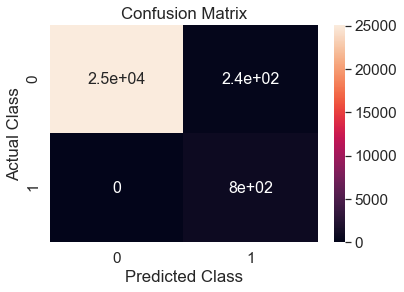

In [8]:
plot_confusion_matrix(original,predicted)